## 本章来探索时间序列之外的特征

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
sns.set_theme(style="whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
main=pd.read_csv('../data/train.csv')
sub=pd.read_csv('../data/store.csv')
sub.head()

/tmp/ipykernel_1727/2652694655.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  main=pd.read_csv('../data/train.csv')


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


store.csv包含了很多关于店铺的信息，将它们合并到主表中

In [4]:
train_data=pd.merge(main,sub,on='Store',how='left')
train_data['Date']=pd.to_datetime(train_data['Date'])
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


先看看商店运行方式

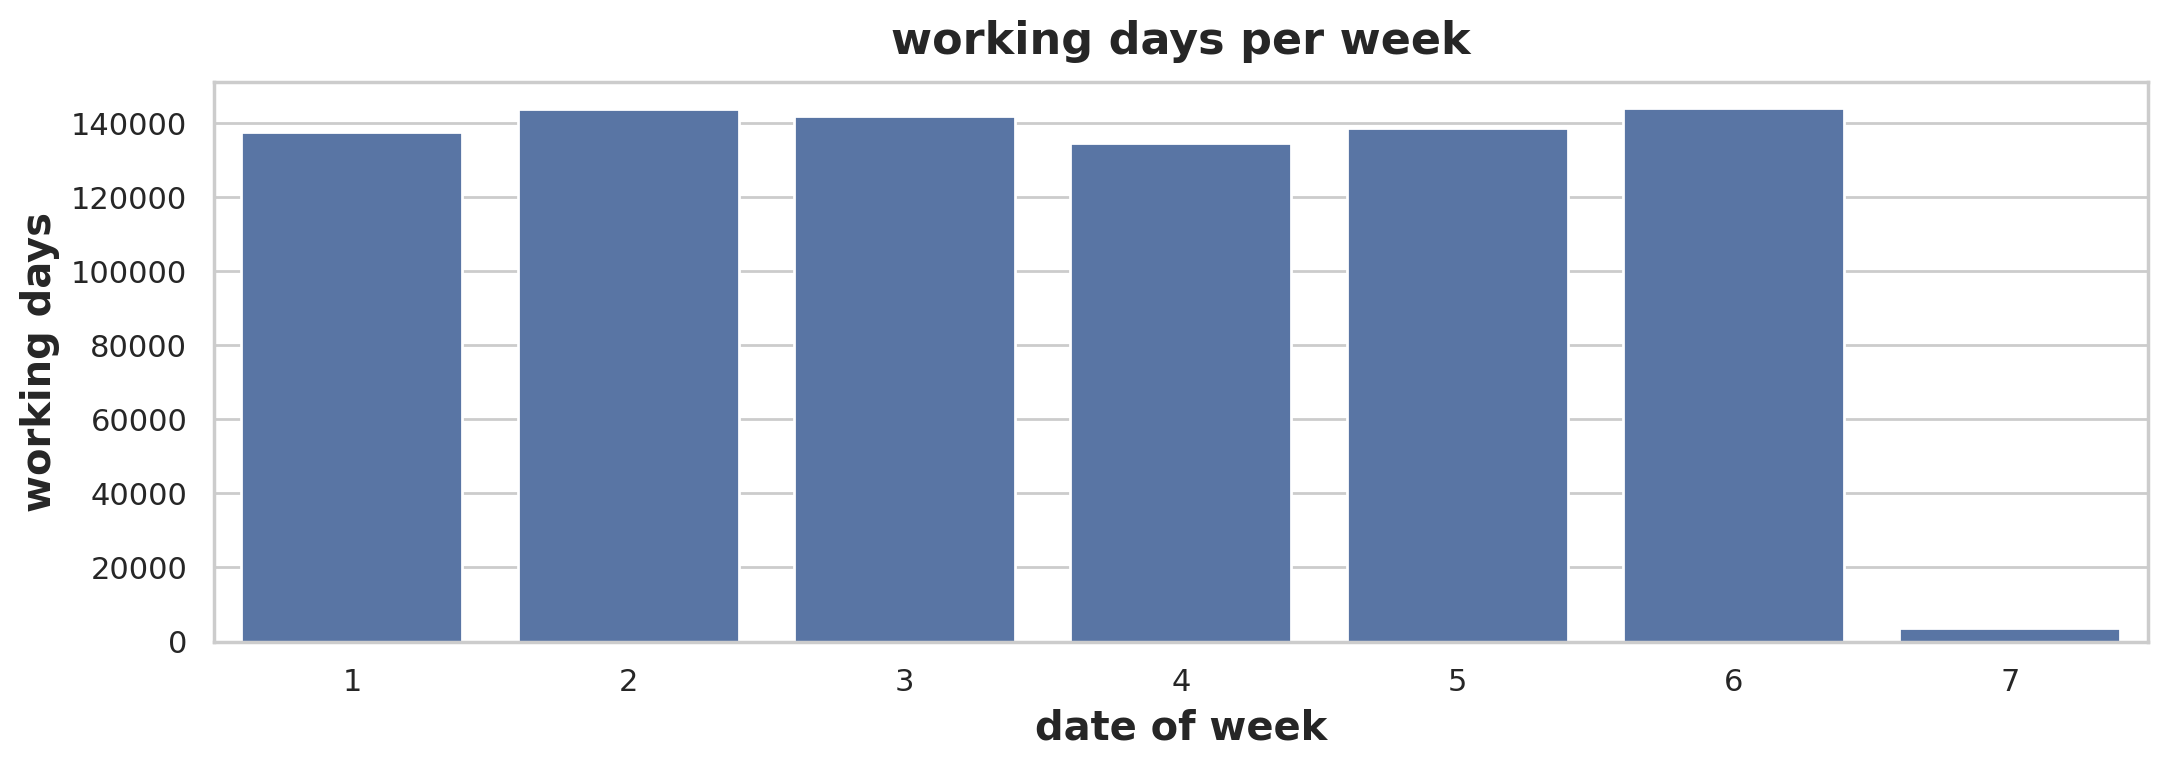

In [5]:
sum_working_days=train_data.groupby(('DayOfWeek'))['Open'].sum()
sns.barplot(x=sum_working_days.index,y=sum_working_days.values)
plt.title('working days per week')
plt.xlabel('date of week')
plt.ylabel('working days')
plt.show()

显然，在常规日期周一到周六营业，周日几乎不营业。接下来看看哪天营业额最高

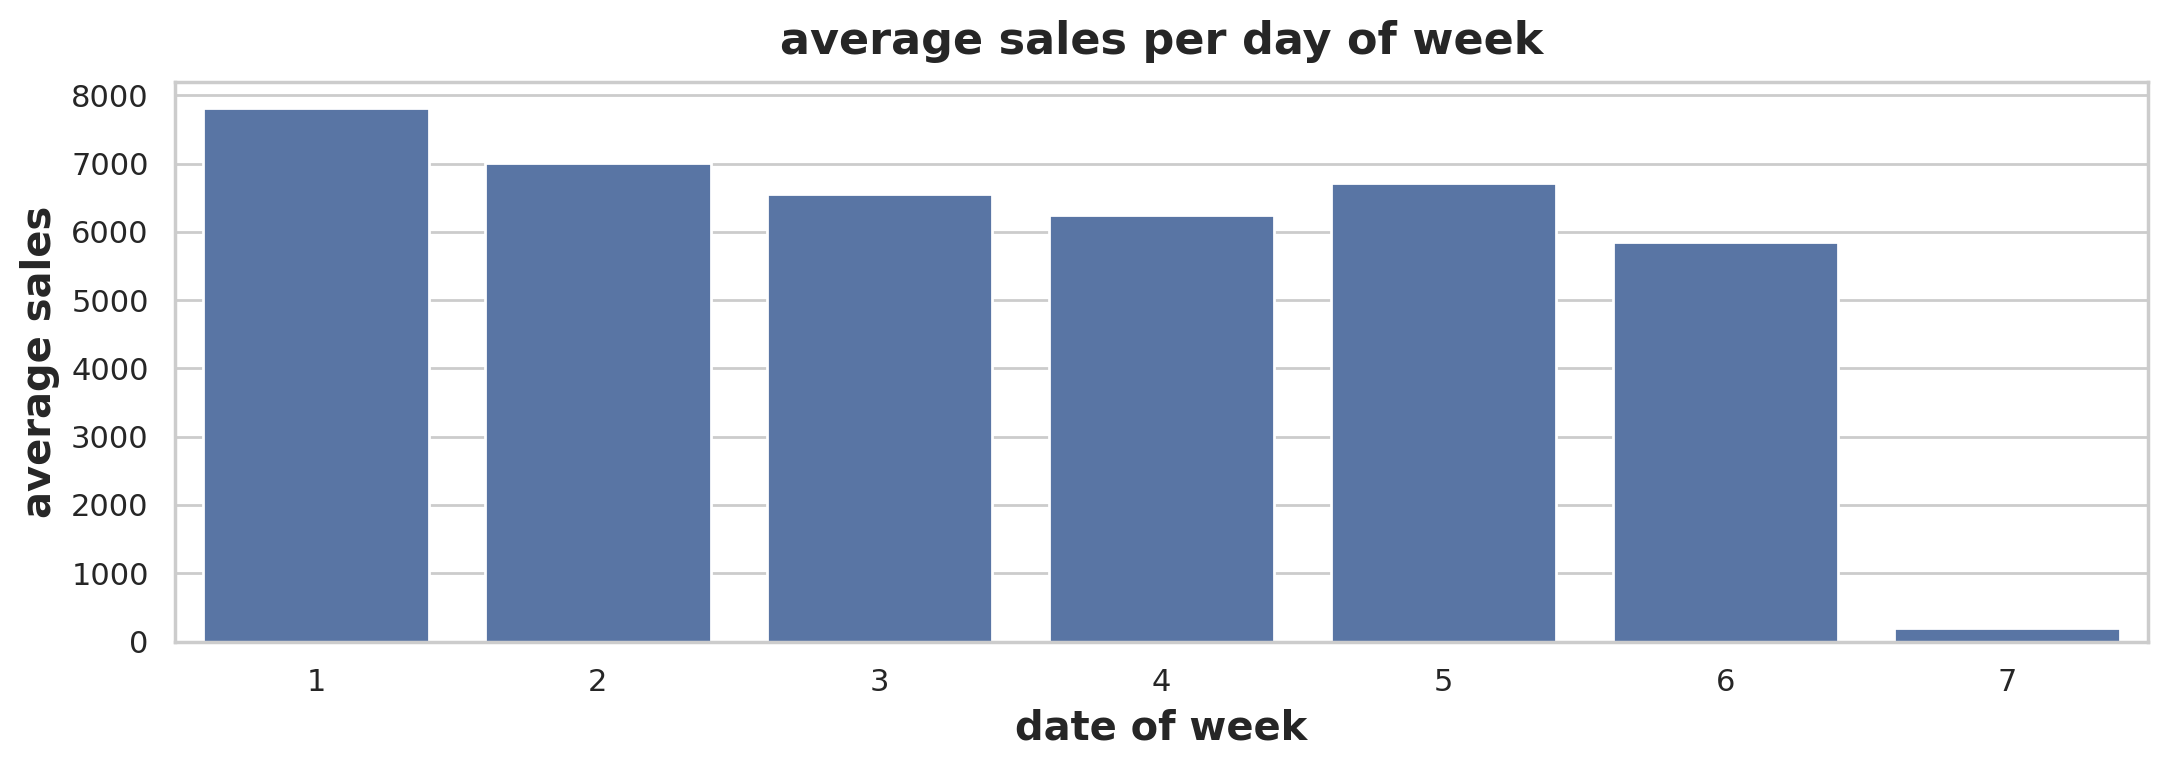

In [6]:
mean_sales=train_data.groupby('DayOfWeek')['Sales'].mean()
sns.barplot(x=mean_sales.index,y=mean_sales.values)
plt.title('average sales per day of week')
plt.xlabel('date of week')
plt.ylabel('average sales')
plt.show()

在正常营业的六天中，从周一到周四营业额不断递减，到周五有所反弹后，周六又有所下降。可以作为一个特征

In [10]:
only_promo2=train_data[(train_data['Promo2']==1)&(train_data['Promo']==1)].copy()
print(f"Number of records with only Promo2 active: {len(only_promo2)}")
only_promo2.head()

Number of records with only Promo2 active: 194016


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


寻找节日有关信息。我们先将每家店每个weeek of day的**基线价格和基线顾客数**创建出来，这样就能方便地分析每一个维度是怎么影响价格的

In [66]:
split_data=train_data[['Date','Store','DayOfWeek','Sales','Customers','Promo']].copy()
split_data.sort_values(by=['Date','Store'],ascending=[True,True],inplace=True)
split_data.set_index('Date',inplace=True)
strandard_data=split_data[split_data['Promo']==0][['Store', 'DayOfWeek', 'Sales', 'Customers']].copy().dropna()
print(f"Number of records without promotion: {len(strandard_data)}")
strandard_data['baseline_sales']=strandard_data.groupby(['Store','DayOfWeek'])['Sales'].transform(lambda x:x.expanding().mean())
strandard_data['baseline_customers']=strandard_data.groupby(['Store','DayOfWeek'])['Customers'].transform(lambda x:x.expanding().mean())
strandard_data.tail()

Number of records without promotion: 629129


,Store,DayOfWeek,Sales,Customers,baseline_sales,baseline_customers
Date,,,,,,
2015-07-26,1111,7,0,0,0.0,0.0
2015-07-26,1112,7,0,0,0.0,0.0
2015-07-26,1113,7,0,0,0.0,0.0
2015-07-26,1114,7,0,0,0.0,0.0
2015-07-26,1115,7,0,0,0.0,0.0


In [67]:
split_data = split_data.reset_index()      # now has column 'Date'
strandard_data = strandard_data.reset_index()
print(split_data.columns)
print(strandard_data.columns)

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo'], dtype='object')
Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'baseline_sales',
       'baseline_customers'],
      dtype='object')


In [72]:
result = pd.merge_asof(
    split_data,
    strandard_data[['Date', 'Store', 'DayOfWeek', 'baseline_sales', 'baseline_customers']],
    by=["Store", "DayOfWeek"],    # 精确匹配
    on="Date",                    # 时间对齐
    direction="backward"        # 向后寻找<=最近的baseline
)

result[(result['Store']==114)&(result['DayOfWeek']==3)].tail(15)

,Date,Store,DayOfWeek,Sales,Customers,Promo,baseline_sales,baseline_customers
904707,2015-04-22,114,3,4684,560,0,4062.859649,507.807018
912512,2015-04-29,114,3,5712,622,1,4062.859649,507.807018
920317,2015-05-06,114,3,6297,622,1,4062.859649,507.807018
928122,2015-05-13,114,3,5549,622,0,4088.482759,509.775862
935927,2015-05-20,114,3,6223,637,1,4088.482759,509.775862
943732,2015-05-27,114,3,4988,585,0,4103.728814,511.050847
951537,2015-06-03,114,3,5408,572,1,4103.728814,511.050847
959342,2015-06-10,114,3,3999,501,0,4101.983333,510.883333
967147,2015-06-17,114,3,5900,601,1,4101.983333,510.883333
974952,2015-06-24,114,3,3929,465,0,4099.147541,510.131148
